#  Importing libraries 

In [19]:
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import zipfile
from PIL import Image
from sklearn.model_selection import KFold
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow import keras
import os
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import random
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from collections import defaultdict
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import DenseNet201
from tensorflow.compat.v1.losses import sparse_softmax_cross_entropy
from sklearn.metrics import *


# Read dataset

In [25]:
# Define constants
image_size = (224, 224)
batch_size = 32
num_classes = 4
epochs = 10

# Set the path to your dataset
dataset_path = 'C:/Users/Muhammad Farhan/Practice/Thesis/Dataset'

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_data_generators(dataset_path, image_size, batch_size):
    
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    # Training and validation generators
    train_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    # Data preprocessing for the test set
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Test generator
    test_generator = test_datagen.flow_from_directory(
        dataset_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # Disable shuffling for the test set
    )

    return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = create_data_generators(dataset_path, image_size, batch_size)


Found 4747 images belonging to 4 classes.
Found 1185 images belonging to 4 classes.
Found 5932 images belonging to 4 classes.


# Exploratory data analysis

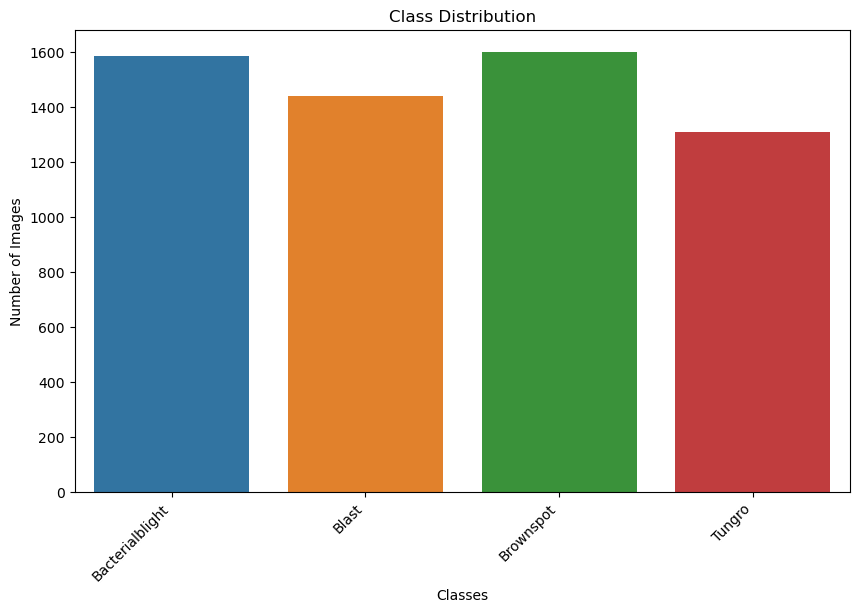

In [5]:
# List the class folders
class_folders = os.listdir(dataset_path)
# Analyze class distribution
class_counts = {}
for class_folder in class_folders:
    class_counts[class_folder] = len(os.listdir(os.path.join(dataset_path, class_folder)))
# Convert class_counts dictionary to a DataFrame
class_df = pd.DataFrame(list(class_counts.items()), columns=['Classes', 'Number of Images'])
# Plot class distribution using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Classes', y='Number of Images', data=class_df)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

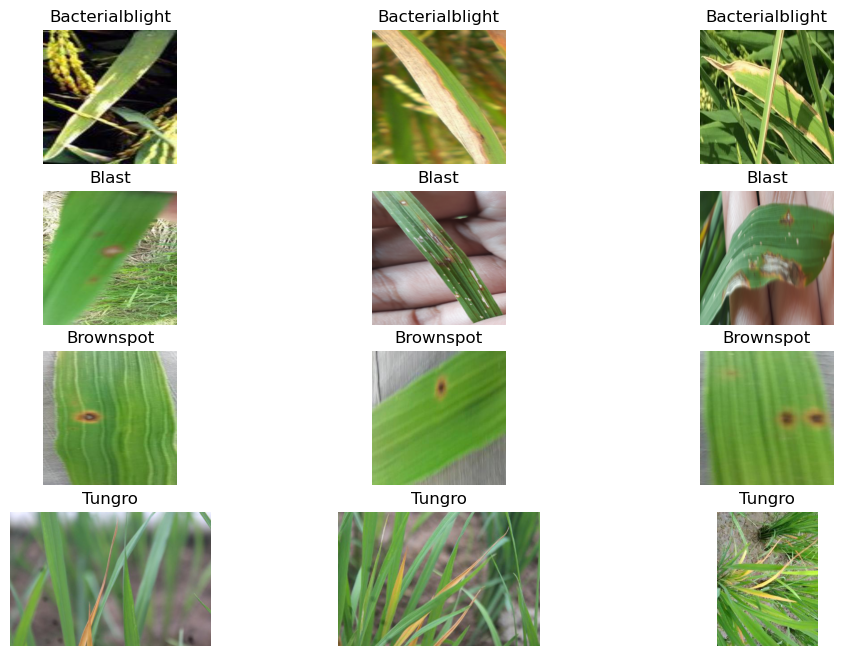

In [10]:
# Display sample images from each class
num_samples = 3  # Number of samples to display from each class
fig, axes = plt.subplots(len(class_folders), num_samples, figsize=(12, 8))

for i, class_folder in enumerate(class_folders):
    class_path = os.path.join(dataset_path, class_folder)
    class_images = random.sample(os.listdir(class_path), num_samples)
    
    for j, image_file in enumerate(class_images):
        image_path = os.path.join(class_path, image_file)
        img = Image.open(image_path)
        axes[i, j].imshow(np.array(img))
        axes[i, j].set_title(class_folder)
        axes[i, j].axis('off')

plt.show()



# In this project 2 models will be created
# vgg19 architecture
# DenseNet architecture


# Building model using vgg19 architecture

In [ ]:
# Build the VGG19 model with added components
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)  # Batch normalization
x = Dropout(0.5)(x)  # Dropout layer
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model with training and validation data
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[early_stopping]  # Early stopping callback
)

# Save the trained model
model.save('rice_leaf_disease_VGG19_model.h5')


In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
# Evaluate the model on the test data
test_results = model.evaluate(test_generator)

# Print the test loss and accuracy
print("Test loss:", test_results[0])
print("Test accuracy:", test_results[1])


186/186 [==============================] - 670s 4s/step - loss: 0.2630 - accuracy: 0.8953
Test loss: 0.2629675567150116
Test accuracy: 0.895313560962677


In [8]:
# Generate predictions for the test data
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, y_pred)
print('Confusion Matrix')
print(conf_matrix)

186/186 [==============================] - 711s 4s/step
Confusion Matrix
[[1580    4    0    0]
 [ 305 1075   58    2]
 [ 211   37 1349    3]
 [   1    0    0 1307]]


In [9]:
# Calculate and display the classification report
target_names = ['Bacterial blight', 'Blast', 'Brown Spot', 'Tungro']
class_report = classification_report(test_generator.classes, y_pred, target_names=target_names, output_dict=True)
print('Classification Report')
print(class_report)


Classification Report
{'Bacterial blight': {'precision': 0.7534573199809251, 'recall': 0.9974747474747475, 'f1-score': 0.8584623743547949, 'support': 1584}, 'Blast': {'precision': 0.9632616487455197, 'recall': 0.7465277777777778, 'f1-score': 0.8411580594679187, 'support': 1440}, 'Brown Spot': {'precision': 0.9587775408670931, 'recall': 0.843125, 'f1-score': 0.8972397738609912, 'support': 1600}, 'Tungro': {'precision': 0.9961890243902439, 'recall': 0.9992354740061162, 'f1-score': 0.9977099236641221, 'support': 1308}, 'accuracy': 0.8953135536075523, 'macro avg': {'precision': 0.9179213834959454, 'recall': 0.8965907498146604, 'f1-score': 0.8986425328369567, 'support': 5932}, 'weighted avg': {'precision': 0.9132893591256106, 'recall': 0.8953135536075523, 'f1-score': 0.8954248524851746, 'support': 5932}}


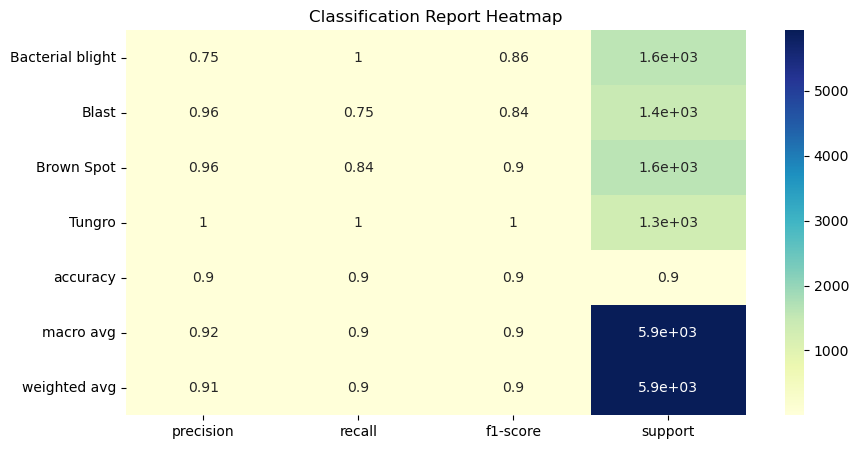

In [10]:
# Create a heatmap plot for the classification report
report_df = pd.DataFrame(class_report).transpose()
plt.figure(figsize=(10, 5))
sns.heatmap(report_df, annot=True, cmap="YlGnBu")
plt.title("Classification Report Heatmap")
plt.show()

186/186 [==============================] - 541s 3s/step


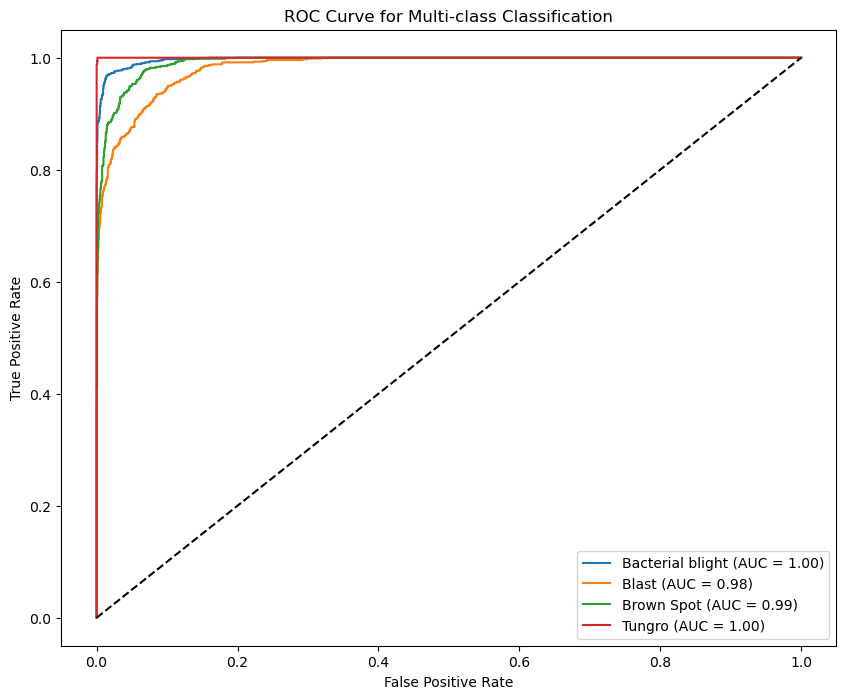

AUC for Bacterial blight: 0.9975
AUC for Blast: 0.9833
AUC for Brown Spot: 0.9920
AUC for Tungro: 1.0000


In [16]:
# Generate predictions for the test data
Y_pred = model.predict(test_generator)

# Assuming you have 4 classes based on your target_names
n_classes = 4

# Calculate AUC for each class
auc_scores = []
for i in range(n_classes):
    true_labels = (test_generator.classes == i).astype(int)
    auc_score = roc_auc_score(true_labels, Y_pred[:, i])
    auc_scores.append(auc_score)

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    true_labels = (test_generator.classes == i).astype(int)
    fpr, tpr, _ = roc_curve(true_labels, Y_pred[:, i])
    plt.plot(fpr, tpr, label=f'{target_names[i]} (AUC = {auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend()
plt.show()

# Print AUC scores for each class
for i in range(n_classes):
    print(f'AUC for {target_names[i]}: {auc_scores[i]:.4f}')


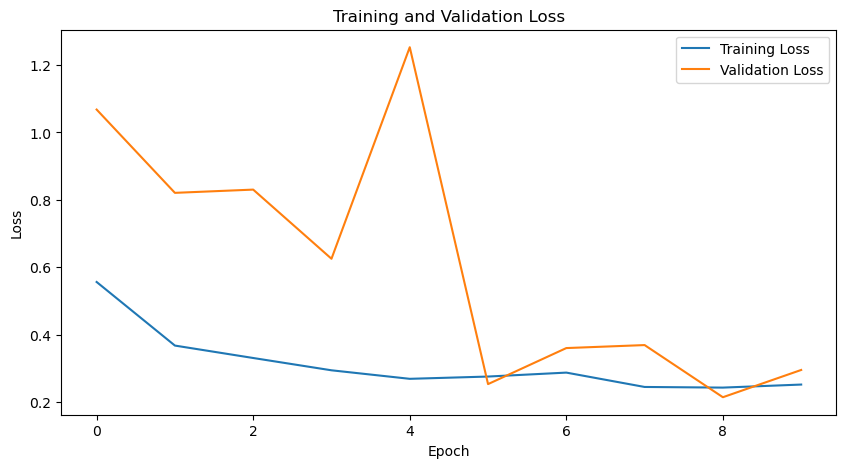

In [11]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

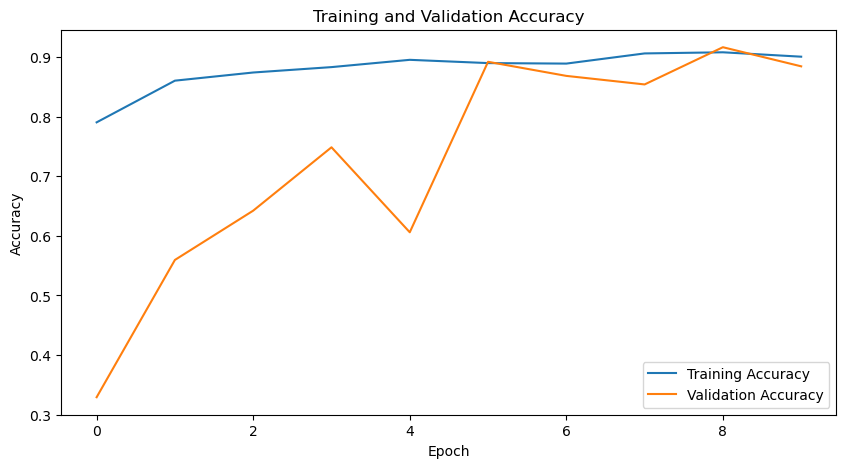

In [12]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Building model using DenseNet architecture

In [23]:
# Build the DenseNet201 model with added components
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)  # Batch normalization
x = Dropout(0.5)(x)  # Dropout layer
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model with training and validation data
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[early_stopping]  # Early stopping callback
)

# Save the trained model
model.save('rice_leaf_disease_densenet_model.h5')


Found 4747 images belonging to 4 classes.
Found 1185 images belonging to 4 classes.
74836368/74836368 [==============================] - 189s 3us/step
Epoch 1/10
149/149 [==============================] - 522s 3s/step - loss: 0.2868 - accuracy: 0.9092 - val_loss: 0.1059 - val_accuracy: 0.9671
Epoch 2/10
149/149 [==============================] - 547s 4s/step - loss: 0.1028 - accuracy: 0.9669 - val_loss: 0.0572 - val_accuracy: 0.9806
Epoch 3/10
149/149 [==============================] - 511s 3s/step - loss: 0.0765 - accuracy: 0.9732 - val_loss: 0.0536 - val_accuracy: 0.9831
Epoch 4/10
149/149 [==============================] - 498s 3s/step - loss: 0.0794 - accuracy: 0.9705 - val_loss: 0.0431 - val_accuracy: 0.9831
Epoch 5/10
149/149 [==============================] - 503s 3s/step - loss: 0.0634 - accuracy: 0.9770 - val_loss: 0.0411 - val_accuracy: 0.9865
Epoch 6/10
149/149 [==============================] - 503s 3s/step - loss: 0.0599 - accuracy: 0.9785 - val_loss: 0.0527 - val_accuracy

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 14, 14, 1024  4096       ['conv4_block24_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 14, 14, 1024  0          ['conv4_block25_0_bn[0][0]']     
 on)      

 lization)                      )                                                                 
                                                                                                  
 conv4_block29_0_relu (Activati  (None, 14, 14, 1152  0          ['conv4_block29_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 14, 14, 128)  147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block33_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block33_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 14, 14, 1312  0          ['conv4_block32_concat[0][0]',   
 ate)                           )                                 'conv4_block33_2_conv[0][0]']   
          

                                                                                                  
 conv4_block37_concat (Concaten  (None, 14, 14, 1440  0          ['conv4_block36_concat[0][0]',   
 ate)                           )                                 'conv4_block37_2_conv[0][0]']   
                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 14, 14, 1440  5760       ['conv4_block37_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 14, 14, 1440  0          ['conv4_block38_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_blo

 conv4_block42_0_relu (Activati  (None, 14, 14, 1568  0          ['conv4_block42_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block42_1_conv (Conv2D)  (None, 14, 14, 128)  200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block46_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block46_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 14, 14, 1728  0          ['conv4_block45_concat[0][0]',   
 ate)                           )                                 'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 14, 14, 1728  6912       ['conv4_block46_concat[0][0]']   
 lization)

                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 128)   512         ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 7, 7, 960)   0           ['conv5_block1_concat[0][0]',    
 te)      

 conv5_block6_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block6_1_relu[0][0]']    
                                                                                                  
 conv5_block6_concat (Concatena  (None, 7, 7, 1088)  0           ['conv5_block5_concat[0][0]',    
 te)                                                              'conv5_block6_2_conv[0][0]']    
                                                                                                  
 conv5_block7_0_bn (BatchNormal  (None, 7, 7, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 7, 7, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block11_0_relu (Activati  (None, 7, 7, 1216)  0           ['conv5_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_1_conv (Conv2D)  (None, 7, 7, 128)    155648      ['conv5_block11_0_relu[0][0]']   
                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block15_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 7, 7, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_blo

 conv5_block19_concat (Concaten  (None, 7, 7, 1504)  0           ['conv5_block18_concat[0][0]',   
 ate)                                                             'conv5_block19_2_conv[0][0]']   
                                                                                                  
 conv5_block20_0_bn (BatchNorma  (None, 7, 7, 1504)  6016        ['conv5_block19_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_0_relu (Activati  (None, 7, 7, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 7, 7, 128)    192512      ['conv5_block20_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv5_block24_1_conv (Conv2D)  (None, 7, 7, 128)    208896      ['conv5_block24_0_relu[0][0]']   
                                                                                                  
 conv5_block24_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block24_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

 conv5_block28_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block28_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block28_1_relu[0][0]']   
                                                                                                  
 conv5_block28_concat (Concaten  (None, 7, 7, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 7, 7, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 bn (BatchNormalization)        (None, 7, 7, 1920)   7680        ['conv5_block32_concat[0][0]']   
                                                                                                  
 relu (Activation)              (None, 7, 7, 1920)   0           ['bn[0][0]']                     
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 1920)        0           ['relu[0][0]']                   
 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_2 (Dense)                (None, 1024)         1967104     ['global_average_pooling2d_1[0][0
                                                                 ]']                              
          

In [25]:
# Evaluate the model on the test data
test_results = model.evaluate(test_generator)

# Print the test loss and accuracy
print("Test loss:", test_results[0])
print("Test accuracy:", test_results[1])

186/186 [==============================] - 490s 3s/step - loss: 0.0105 - accuracy: 0.9963
Test loss: 0.010490208864212036
Test accuracy: 0.9962912797927856


In [26]:
# Generate predictions for the test data
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, y_pred)
print('Confusion Matrix')
print(conf_matrix)

186/186 [==============================] - 475s 3s/step
Confusion Matrix
[[1580    4    0    0]
 [   6 1428    6    0]
 [   0    6 1594    0]
 [   0    0    0 1308]]


In [27]:
# Calculate and display the classification report
target_names = ['Bacterial blight', 'Blast', 'Brown Spot', 'Tungro']
class_report = classification_report(test_generator.classes, y_pred, target_names=target_names, output_dict=True)
print('Classification Report')
print(class_report)

Classification Report
{'Bacterial blight': {'precision': 0.9962168978562421, 'recall': 0.9974747474747475, 'f1-score': 0.9968454258675079, 'support': 1584}, 'Blast': {'precision': 0.9930458970792768, 'recall': 0.9916666666666667, 'f1-score': 0.9923558026407228, 'support': 1440}, 'Brown Spot': {'precision': 0.99625, 'recall': 0.99625, 'f1-score': 0.99625, 'support': 1600}, 'Tungro': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1308}, 'accuracy': 0.9962913014160486, 'macro avg': {'precision': 0.9963781987338797, 'recall': 0.9963478535353535, 'f1-score': 0.9963628071270576, 'support': 5932}, 'weighted avg': {'precision': 0.9962902322991312, 'recall': 0.9962913014160486, 'f1-score': 0.9962905445678985, 'support': 5932}}


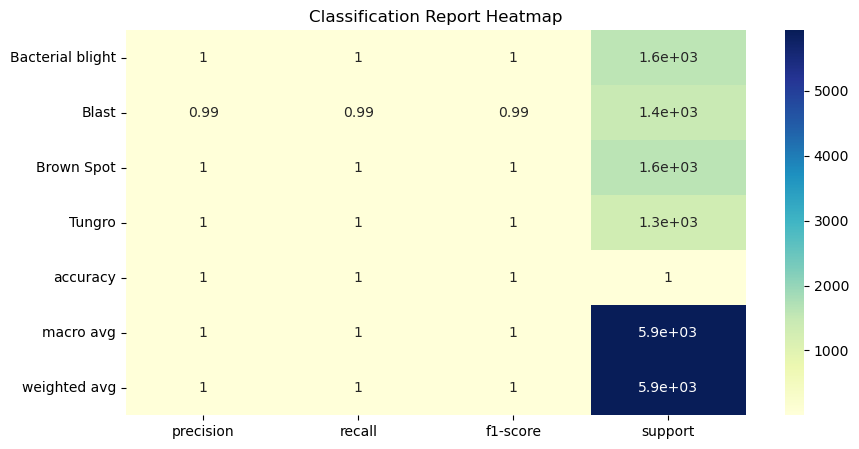

In [28]:
# Create a heatmap plot for the classification report
report_df = pd.DataFrame(class_report).transpose()
plt.figure(figsize=(10, 5))
sns.heatmap(report_df, annot=True, cmap="YlGnBu")
plt.title("Classification Report Heatmap")
plt.show()

186/186 [==============================] - 303s 2s/step


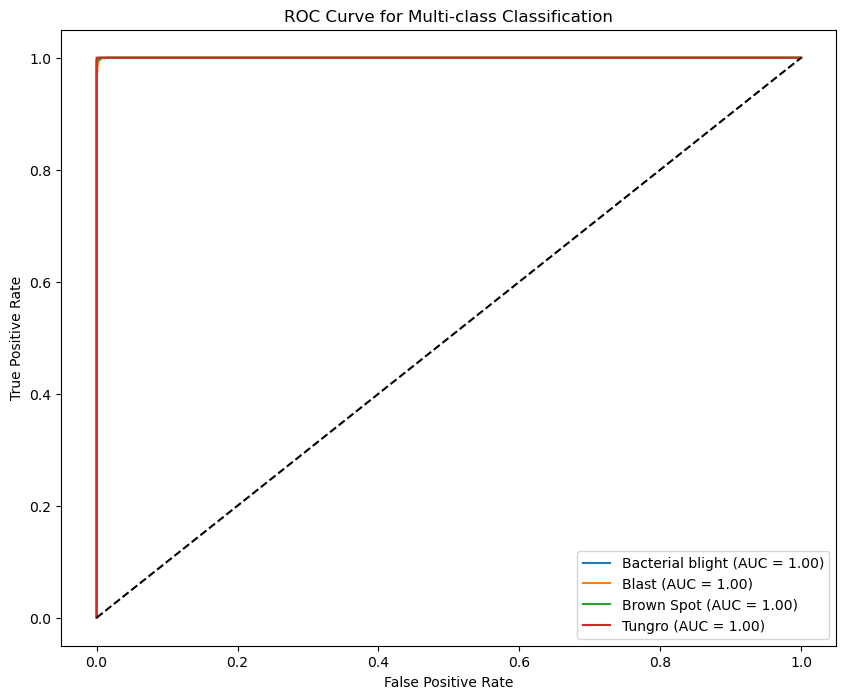

AUC for Bacterial blight: 1.0000
AUC for Blast: 0.9999
AUC for Brown Spot: 1.0000
AUC for Tungro: 1.0000


In [13]:
# Generate predictions for the test data
Y_pred = model.predict(test_generator)

# Assuming you have 4 classes based on your target_names
n_classes = 4

# Calculate AUC for each class
auc_scores = []
for i in range(n_classes):
    true_labels = (test_generator.classes == i).astype(int)
    auc_score = roc_auc_score(true_labels, Y_pred[:, i])
    auc_scores.append(auc_score)

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    true_labels = (test_generator.classes == i).astype(int)
    fpr, tpr, _ = roc_curve(true_labels, Y_pred[:, i])
    plt.plot(fpr, tpr, label=f'{target_names[i]} (AUC = {auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend()
plt.show()

# Print AUC scores for each class
for i in range(n_classes):
    print(f'AUC for {target_names[i]}: {auc_scores[i]:.4f}')


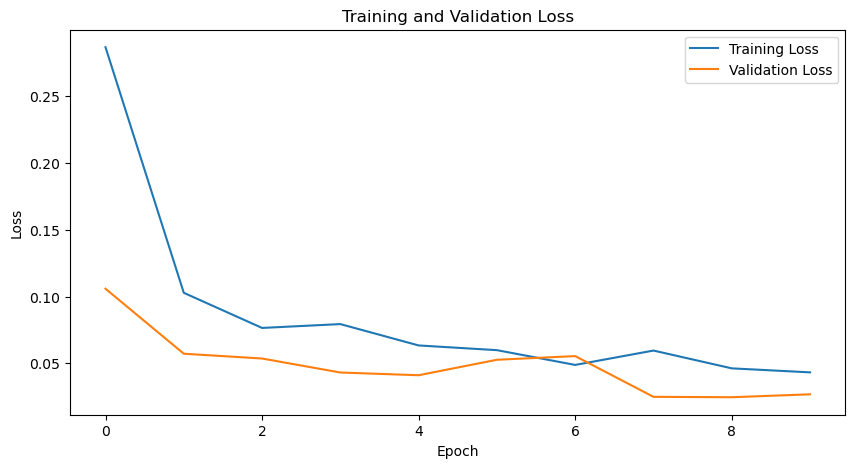

In [29]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

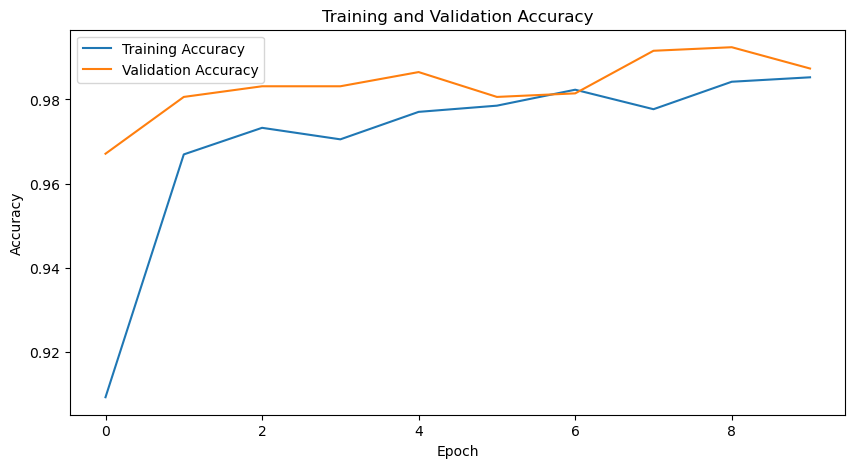

In [30]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Model comparison

In [20]:
# Load the first model
model1 = load_model('rice_leaf_disease_VGG19_model.h5')

# Load the second model
model2 = load_model('rice_leaf_disease_densenet_model.h5')

# Generate predictions for the test data
Y_pred1 = model1.predict(test_generator)
y_pred1 = np.argmax(Y_pred1, axis=1)
accuracy_model1 = accuracy_score(test_generator.classes, y_pred1)

Y_pred2 = model2.predict(test_generator)
y_pred2 = np.argmax(Y_pred2, axis=1)
accuracy_model2 = accuracy_score(test_generator.classes, y_pred2)




186/186 [==============================] - 304s 2s/step


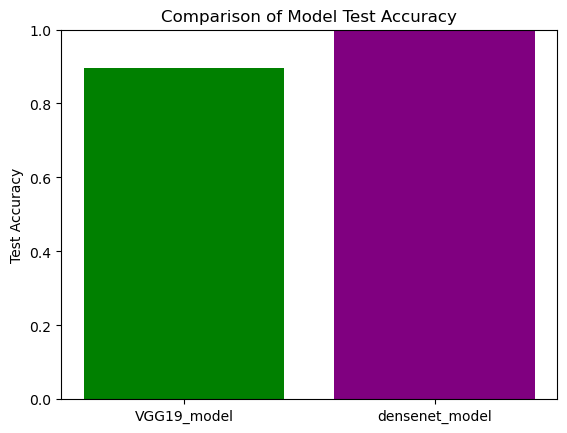

In [24]:
# Bar plot for model comparison
models = ['VGG19_model', 'densenet_model']
accuracies = [accuracy_model1, accuracy_model2]

plt.bar(models, accuracies, color=['green', 'purple'])
plt.ylabel('Test Accuracy')
plt.title('Comparison of Model Test Accuracy')
plt.ylim(0, 1.0)  # Assuming accuracy is between 0 and 1
plt.show()